In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from scipy.spatial.distance import euclidean
from joblib import Parallel, delayed
from fastdtw import fastdtw
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow import keras
import tensorflow as tf
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score,accuracy_score,classification_report

In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [25]:
attack_df = pd.read_csv('/content/drive/My Drive/swat/SWaT_Dataset_Normal_v0.csv')
normal_df = pd.read_csv('/content/drive/My Drive/swat/SWaT_Dataset_Attack_v0.csv')

In [3]:
!pip install fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512619 sha256=cd20f5600111f373bd41b4015003c16c624deec9c9d4d8345cd98993fe4d4906
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


In [26]:
# Combine the datasets
combined_df = pd.concat([normal_df, attack_df], ignore_index=True)

In [120]:
print(combined_df.shape)
combined_df.head()

(946719, 53)


,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,28/12/2015 10:00:00 AM,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,...,2,1,250.8652,1.649953,189.5988,0.000128,1,1,1,Normal
1,28/12/2015 10:00:01 AM,2.446274,522.8860,2,2,1,262.0161,8.396437,328.6337,2.445391,...,2,1,250.8652,1.649953,189.6789,0.000128,1,1,1,Normal
2,28/12/2015 10:00:02 AM,2.489191,522.8467,2,2,1,262.0161,8.394514,328.6337,2.442316,...,2,1,250.8812,1.649953,189.6789,0.000128,1,1,1,Normal
3,28/12/2015 10:00:03 AM,2.534350,522.9645,2,2,1,262.0161,8.394514,328.6337,2.442316,...,2,1,250.8812,1.649953,189.6148,0.000128,1,1,1,Normal
4,28/12/2015 10:00:04 AM,2.569260,523.4748,2,2,1,262.0161,8.394514,328.6337,2.443085,...,2,1,250.8812,1.649953,189.5027,0.000128,1,1,1,Normal


In [227]:
combined_df['Normal/Attack'].unique()

array(['Normal', 'Attack', 'A ttack'], dtype=object)

In [228]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 946719 entries, 0 to 946718
Data columns (total 53 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Timestamp      946719 non-null  object 
 1   FIT101         946719 non-null  float64
 2   LIT101         946719 non-null  float64
 3   MV101          946719 non-null  int64  
 4   P101           946719 non-null  int64  
 5   P102           946719 non-null  int64  
 6   AIT201         946719 non-null  float64
 7   AIT202         946719 non-null  float64
 8   AIT203         946719 non-null  float64
 9   FIT201         946719 non-null  float64
 10  MV201          946719 non-null  int64  
 11  P201           946719 non-null  int64  
 12  P202           946719 non-null  int64  
 13  P203           946719 non-null  int64  
 14  P204           946719 non-null  int64  
 15  P205           946719 non-null  int64  
 16  P206           946719 non-null  int64  
 17  DPIT301        946719 non-nul

In [229]:
combined_df['Normal/Attack'] = combined_df['Normal/Attack'].str.replace(' ', '')

In [230]:
combined_df['Normal/Attack'].unique()

array(['Normal', 'Attack'], dtype=object)

In [231]:
class_distribution = combined_df['Normal/Attack'].value_counts()

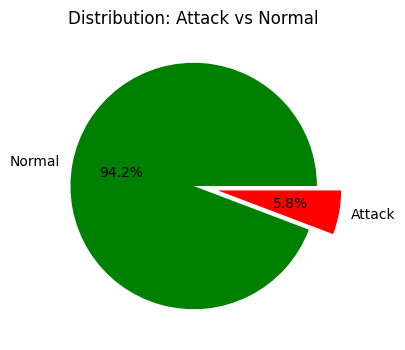

In [232]:
plt.figure(figsize=(4, 4))
plt.pie(class_distribution, labels=class_distribution.index, explode=[0, 0.2], autopct='%1.1f%%', colors=['g', 'r'])
plt.title('Distribution: Attack vs Normal')
plt.show()

In [233]:
combined_df['Timestamp'] = combined_df['Timestamp'].str.strip()

try:
    combined_df['Timestamp'] = pd.to_datetime(combined_df['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')
except ValueError:
    combined_df['Timestamp'] = pd.to_datetime(combined_df['Timestamp'], infer_datetime_format=True, dayfirst=True)

In [234]:
combined_df = combined_df.set_index('Timestamp')

In [235]:
combined_df.head()

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
Timestamp,,,,,,,,,,,,,,,,,,,,,
2015-12-28 10:00:00,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,2,...,2,1,250.8652,1.649953,189.5988,0.000128,1,1,1,Normal
2015-12-28 10:00:01,2.446274,522.8860,2,2,1,262.0161,8.396437,328.6337,2.445391,2,...,2,1,250.8652,1.649953,189.6789,0.000128,1,1,1,Normal
2015-12-28 10:00:02,2.489191,522.8467,2,2,1,262.0161,8.394514,328.6337,2.442316,2,...,2,1,250.8812,1.649953,189.6789,0.000128,1,1,1,Normal
2015-12-28 10:00:03,2.534350,522.9645,2,2,1,262.0161,8.394514,328.6337,2.442316,2,...,2,1,250.8812,1.649953,189.6148,0.000128,1,1,1,Normal
2015-12-28 10:00:04,2.569260,523.4748,2,2,1,262.0161,8.394514,328.6337,2.443085,2,...,2,1,250.8812,1.649953,189.5027,0.000128,1,1,1,Normal


In [236]:
attack_data = combined_df[combined_df['Normal/Attack'] == 'Attack']

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


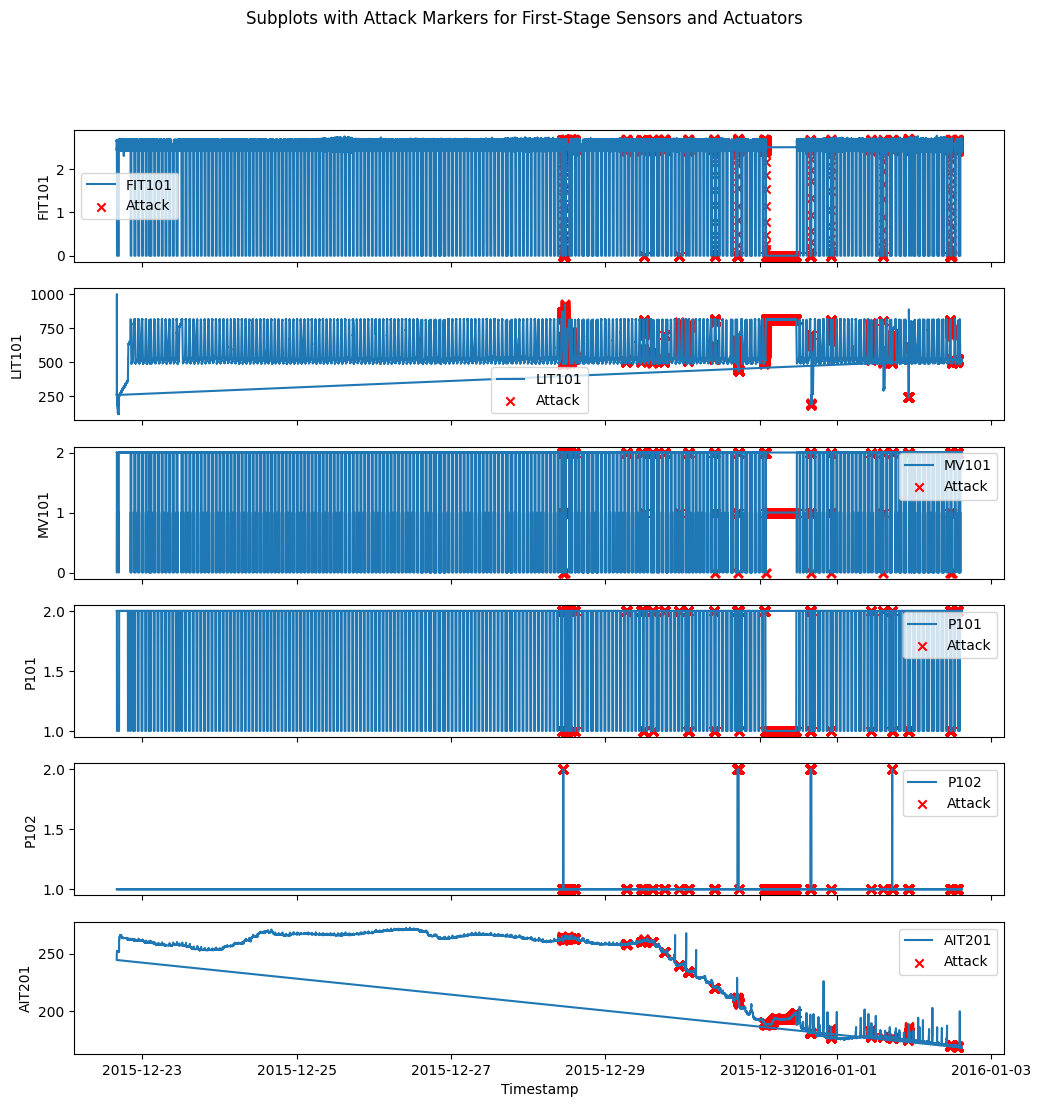

In [131]:
# List of all sensors and actuators in the first stage
first_stage_features = ['FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201']

# Number of features
num_features = len(first_stage_features)

# Create subplots
fig, axes = plt.subplots(num_features, 1, figsize=(12, 2 * num_features), sharex=True)

# Plot each feature in a separate subplot
for i, feature in enumerate(first_stage_features):
    axes[i].plot(combined_df.index, combined_df[feature], label=feature)
    axes[i].scatter(attack_data.index, attack_data[feature], color='red', marker='x', label='Attack')
    axes[i].set_ylabel(feature)
    axes[i].legend()

plt.xlabel('Timestamp')
plt.suptitle('Subplots with Attack Markers for First-Stage Sensors and Actuators')
plt.show()

In [237]:
combined_df.dropna(inplace=True)
combined_df.drop_duplicates(inplace=True)

combined_df.shape

(928898, 52)

In [238]:
combined_df=combined_df.loc[:, combined_df.nunique() > 1]

In [239]:
combined_df.loc[:, 'Normal/Attack'] = combined_df['Normal/Attack'].apply(lambda x: 1 if x == 'Attack' else 0)

In [27]:
combined_df.head()

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,28/12/2015 10:00:00 AM,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,...,2,1,250.8652,1.649953,189.5988,0.000128,1,1,1,Normal
1,28/12/2015 10:00:01 AM,2.446274,522.8860,2,2,1,262.0161,8.396437,328.6337,2.445391,...,2,1,250.8652,1.649953,189.6789,0.000128,1,1,1,Normal
2,28/12/2015 10:00:02 AM,2.489191,522.8467,2,2,1,262.0161,8.394514,328.6337,2.442316,...,2,1,250.8812,1.649953,189.6789,0.000128,1,1,1,Normal
3,28/12/2015 10:00:03 AM,2.534350,522.9645,2,2,1,262.0161,8.394514,328.6337,2.442316,...,2,1,250.8812,1.649953,189.6148,0.000128,1,1,1,Normal
4,28/12/2015 10:00:04 AM,2.569260,523.4748,2,2,1,262.0161,8.394514,328.6337,2.443085,...,2,1,250.8812,1.649953,189.5027,0.000128,1,1,1,Normal


In [241]:
X = combined_df.drop('Normal/Attack', axis=1)
y= combined_df['Normal/Attack']
y = y.reset_index(drop=True)

In [242]:
y

0         0
1         0
2         0
3         0
4         0
         ..
928893    0
928894    0
928895    0
928896    0
928897    0
Name: Normal/Attack, Length: 928898, dtype: object

In [243]:
# Saparate Numerical and categorical features
numerical_features = []
categorical_features = []

for column in X.columns:
    unique_values = X[column].nunique()
    if unique_values > 10:
        numerical_features.append(column)
    else:
        categorical_features.append(column)

In [244]:
print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

Numerical Features: ['FIT101', 'LIT101', 'AIT201', 'AIT202', 'AIT203', 'FIT201', 'DPIT301', 'FIT301', 'LIT301', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'PIT501', 'PIT502', 'PIT503', 'FIT601']
Categorical Features: ['MV101', 'P101', 'P102', 'MV201', 'P201', 'P203', 'P204', 'P205', 'P206', 'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302', 'P402', 'P403', 'UV401', 'P501', 'P602']


In [245]:
numerical_data = combined_df[numerical_features]
categorical_data = combined_df[categorical_features]

# Min-Max scaling for numerical features
scaler = MinMaxScaler()
numerical_data_scaled = scaler.fit_transform(numerical_data)
numerical_data_scaled_df = pd.DataFrame(numerical_data_scaled, columns=numerical_data.columns)

In [246]:
# One-hot encoding for categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoder.fit(categorical_data)

categorical_feature_names = encoder.get_feature_names_out(categorical_data.columns)
categorical_data_encoded = encoder.transform(categorical_data)
categorical_data_encoded_df = pd.DataFrame(categorical_data_encoded, columns=categorical_feature_names)

In [247]:
preprocessed_data = pd.concat([numerical_data_scaled_df, categorical_data_encoded_df,y], axis=1)

In [248]:
preprocessed_data.head()

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,MV304_1,MV304_2,P301_2,P302_2,P402_2,P403_2,UV401_2,P501_2,P602_2,Normal/Attack
0,0.879322,0.457396,0.899417,0.801947,0.153462,0.865044,0.438853,0.928726,0.770793,0.999677,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0
1,0.886285,0.457440,0.899417,0.801947,0.153462,0.865044,0.438853,0.929319,0.770793,0.999677,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0
2,0.901833,0.457396,0.899417,0.801304,0.153462,0.863956,0.437572,0.929480,0.771093,0.999677,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0
3,0.918195,0.457530,0.899417,0.801304,0.153462,0.863956,0.437572,0.929480,0.771393,0.999677,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0
4,0.930842,0.458110,0.899417,0.801304,0.153462,0.864228,0.437572,0.929480,0.771655,0.999677,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0


In [146]:
# Saving preprocessed data to a local drive
preprocessed_data.to_csv('/content/drive/My Drive/swat/preprocessed_data.csv', index=False)

In [147]:
SWAT_prep = pd.read_csv('/content/drive/My Drive/swat/preprocessed_data.csv')

In [148]:
sensors=['FIT101','LIT101']

In [149]:
X=SWAT_prep

In [152]:
SWAT_prep

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,MV304_1,MV304_2,P301_2,P302_2,P402_2,P403_2,UV401_2,P501_2,P602_2,Normal/Attack
0,0.879322,0.457396,0.899417,0.801947,0.153462,0.865044,0.438853,0.928726,0.770793,0.999677,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0
1,0.886285,0.457440,0.899417,0.801947,0.153462,0.865044,0.438853,0.929319,0.770793,0.999677,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0
2,0.901833,0.457396,0.899417,0.801304,0.153462,0.863956,0.437572,0.929480,0.771093,0.999677,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0
3,0.918195,0.457530,0.899417,0.801304,0.153462,0.863956,0.437572,0.929480,0.771393,0.999677,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0
4,0.930842,0.458110,0.899417,0.801304,0.153462,0.864228,0.437572,0.929480,0.771655,0.999677,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
928893,0.895451,0.457708,0.899417,0.801947,0.153007,0.864182,0.438853,0.930936,0.770455,0.999677,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0
928894,0.891390,0.457619,0.899417,0.801947,0.153007,0.863956,0.438853,0.930936,0.770455,0.999677,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0
928895,0.887213,0.457530,0.899417,0.801947,0.153007,0.863956,0.438853,0.930073,0.770530,0.999677,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0
928896,0.882107,0.457440,0.899417,0.801947,0.153462,0.864863,0.438853,0.929103,0.770605,0.999677,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0


In [151]:
sampled_data = X.sample(n=3000, random_state=42)
sampled_data = sampled_data.astype(np.float64)

In [153]:
sampled_data_dtw=sampled_data[sensors]

In [154]:
sampled_data_dtw

,FIT101,LIT101
693046,0.000000,0.787040
916789,0.891042,0.469716
292515,0.961592,0.465788
738953,0.000000,0.775167
748096,0.927941,0.433738
...,...,...
841434,0.952773,0.439228
170039,0.000000,0.787308
299748,0.000000,0.775970
575622,0.000000,0.788692


In [155]:
dtw_columns = sampled_data.columns

In [156]:
def calculate_dtw_distance(s1, s2):
    distance, _ = fastdtw(s1, s2)
    return distance

In [157]:
def calculate_dtw_parallel(row, df, dtw_columns):
    current_seq = row[dtw_columns].values.flatten()
    distances = []

    for idx, r in df.iterrows():
        if row.name != idx:
            compared_seq = r[dtw_columns].values.flatten()
            distance = calculate_dtw_distance(current_seq, compared_seq)
            distances.append(distance)

    min_distance = min(distances) if distances else None
    return min_distance

In [158]:
num_cores = -1
dtw_distances = Parallel(n_jobs=num_cores)(
    delayed(calculate_dtw_parallel)(row, sampled_data, dtw_columns) for _, row in sampled_data.iterrows())

In [159]:
sampled_data['dtw_distances'] = dtw_distances

In [76]:
# Save sampled_data + dtw distances to drive
sampled_data.to_csv('/content/drive/My Drive/swat/dtw_sampled_data.csv', index=False)

In [77]:
sampled_data.head(3)

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,MV304_2,P301_2,P302_2,P402_2,P403_2,UV401_2,P501_2,P602_2,dtw_distances,Normal/Attack
0,0.000000,0.787040,0.941428,0.815887,0.116755,0.000000,0.439991,0.931475,0.657026,0.999645,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.078246,0.0
1,0.891042,0.469716,0.885311,0.795620,0.159277,0.862097,0.440631,0.930343,0.786242,0.999645,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.084226,0.0
2,0.961592,0.465788,0.083411,0.874863,0.083318,0.866449,0.452583,0.927485,0.801766,0.999580,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.170862,0.0


In [162]:
sampled_data.columns

Index(['FIT101', 'LIT101', 'AIT201', 'AIT202', 'AIT203', 'FIT201', 'DPIT301',
       'FIT301', 'LIT301', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'AIT501',
       'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504',
       'PIT501', 'PIT502', 'PIT503', 'FIT601', 'MV101_1', 'MV101_2', 'P101_2',
       'P102_2', 'MV201_1', 'MV201_2', 'P201_2', 'P203_2', 'P204_2', 'P205_2',
       'P206_2', 'MV301_1', 'MV301_2', 'MV302_1', 'MV302_2', 'MV303_1',
       'MV303_2', 'MV304_1', 'MV304_2', 'P301_2', 'P302_2', 'P402_2', 'P403_2',
       'UV401_2', 'P501_2', 'P602_2', 'Normal/Attack', 'dtw_distances'],
      dtype='object')

In [44]:
sampled_data = pd.read_csv('/content/drive/My Drive/swat/dtw_sampled_data.csv')

In [161]:
#without DTW
#X_sampled = sampled_data.drop(columns=['Normal/Attack', 'dtw_distances']) #removing dtw distance feature
#y_sampled = sampled_data['Normal/Attack']

In [90]:
#with DTW
#X_sampled = sampled_data.drop(columns=['Normal/Attack'])
#y_sampled = sampled_data['Normal/Attack']

**LSTM with DTW**


In [45]:
counts = sampled_data['Normal/Attack'].value_counts()
print(counts)

Normal/Attack
0.0    2809
1.0     191
Name: count, dtype: int64


In [93]:
X_sampled=sampled_data #with DTW
y_sampled=X_sampled['Normal/Attack']

In [94]:
print(X_sampled.shape)
print(y_sampled.shape)

(3000, 54)
(3000,)


In [95]:
def create_3d_array(data, window_size):
    samples, features = data.shape
    new_samples = samples - window_size + 1

    # Initialize an empty array for the 3D data
    result = np.zeros((new_samples, window_size, features))

    # Populate the 3D array using a rolling window
    for i in range(new_samples):
        result[i, :, :] = data.iloc[i:i+window_size, :].values

    return result

In [96]:
window_size = 60
X_sampled_reshaped = create_3d_array(X_sampled, window_size)

In [97]:
y_sampled_reshaped = X_sampled_reshaped[:, :, -1:]
X_sampled_reshaped = X_sampled_reshaped[:, :, :-1]

In [205]:
X_train_S, X_test_S, y_train_S, y_test_S = train_test_split(X_sampled_reshaped, y_sampled_reshaped, test_size=0.2, random_state=42)

window_size = X_train_S.shape[1]
number_of_features = X_train_S.shape[2]

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True, input_shape=(window_size, number_of_features)),
    tf.keras.layers.LSTM(32, activation='tanh', return_sequences=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.RepeatVector(window_size),
    tf.keras.layers.LSTM(32, activation='tanh', return_sequences=True),
    tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, clipvalue=1.0)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 60, 64)            30208     
                                                                 
 lstm_17 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 repeat_vector_4 (RepeatVec  (None, 60, 32)            0         
 tor)                                                            
                                                                 
 lstm_18 (LSTM)              (None, 60, 32)            8320      
                                                                 
 lstm_19 (LSTM)              (None, 60, 64)            24832     
                                                      

In [189]:
import joblib

model_filename = '/content/drive/My Drive/swat/anomaly_detection_lstm_model.pkl'
joblib.dump(model, model_filename)

['/content/drive/My Drive/swat/anomaly_detection_lstm_model.pkl']

In [213]:
history = model.fit(X_train_S, y_train_S, epochs=100, batch_size=128, validation_split=0.1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)], verbose=1)

Epoch 1/100
17/17 [==============================] - 8s 481ms/step - loss: 0.0562 - val_loss: 0.0557
Epoch 2/100
17/17 [==============================] - 4s 245ms/step - loss: 0.0562 - val_loss: 0.0556
Epoch 3/100
17/17 [==============================] - 6s 344ms/step - loss: 0.0561 - val_loss: 0.0555
Epoch 4/100
17/17 [==============================] - 4s 226ms/step - loss: 0.0560 - val_loss: 0.0552
Epoch 5/100
17/17 [==============================] - 4s 240ms/step - loss: 0.0559 - val_loss: 0.0550
Epoch 6/100
17/17 [==============================] - 6s 338ms/step - loss: 0.0558 - val_loss: 0.0550
Epoch 7/100
17/17 [==============================] - 4s 235ms/step - loss: 0.0557 - val_loss: 0.0549
Epoch 8/100
17/17 [==============================] - 4s 226ms/step - loss: 0.0556 - val_loss: 0.0548
Epoch 9/100
17/17 [==============================] - 4s 258ms/step - loss: 0.0555 - val_loss: 0.0549
Epoch 10/100
17/17 [==============================] - 5s 305ms/step - loss: 0.0554 - val_lo

In [214]:
y_pred = model.predict(X_test_S)
y_test_final = y_test_S[:,0,:]
y_pred_final = y_pred[:,0,:]


mse = np.mean(np.power(y_test_final - y_pred_final, 2), axis=1)

threshold = np.percentile(mse, 85)
threshold
y_pred = (mse > threshold).astype(int)

19/19 [==============================] - 1s 54ms/step


In [215]:
threshold

0.004979587913919137

In [216]:
precision = precision_score(y_test_final, y_pred)
recall = recall_score(y_test_final, y_pred)
f1 = f1_score(y_test_final, y_pred)

In [210]:
# Print all evaluation metrics
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Precision: 0.3707865168539326
Recall: 1.0
F1-score: 0.5409836065573771


In [217]:
# Print all evaluation metrics
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Precision: 0.3707865168539326
Recall: 1.0
F1-score: 0.5409836065573771


In [218]:
accuracy = accuracy_score(y_test_final, y_pred)
conf_matrix = confusion_matrix(y_test_final, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9049235993208828
Confusion Matrix:
[[500  56]
 [  0  33]]


**Baseline LSTM**

In [3]:
df=pd.read_csv('/content/drive/My Drive/swat/preprocessed_data.csv')

In [4]:
df.head(3)

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,MV304_1,MV304_2,P301_2,P302_2,P402_2,P403_2,UV401_2,P501_2,P602_2,Normal/Attack
0,0.879322,0.457396,0.899417,0.801947,0.153462,0.865044,0.438853,0.928726,0.770793,0.999677,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0
1,0.886285,0.457440,0.899417,0.801947,0.153462,0.865044,0.438853,0.929319,0.770793,0.999677,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0
2,0.901833,0.457396,0.899417,0.801304,0.153462,0.863956,0.437572,0.929480,0.771093,0.999677,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0


In [5]:
import numpy as np

window_size = 60
overlap_size = 115

sequences = []
labels = []

for i in range(0, len(df) - window_size + 1, overlap_size):
    window = df.iloc[i:i + window_size]
    sequence = window.values
    label = window['Normal/Attack'].values[-1]
    sequences.append(sequence)
    labels.append(label)

sequences = np.array(sequences)
labels = np.array(labels)

In [23]:
df_labels = sequences[:, :, -1:]
sequences = sequences[:, :, :-1]

In [9]:
# Define sliding window parameters
window_size = 60
overlap_size = 115

# Create sequences for training using sliding window approach
sequences = []
df_labels = []

for i in range(0, len(df) - window_size, overlap_size):
    seq = df.iloc[i:i + window_size].values
    sequences.append(seq)
    df_labels.append(df['Normal/Attack'].iloc[i + window_size - 1])

In [10]:
df = df.drop(columns=['Normal/Attack'])

In [25]:
df_labels.shape

(8077, 60, 1)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(sequences, df_labels, test_size=0.2, random_state=42)

In [60]:
X_test.shape

(1616, 60, 51)

In [61]:
#import numpy as np
#X_train = np.array(X_train)
#print(X_train.shape)

In [62]:
window_size = X_train.shape[1]
number_of_features = X_train.shape[2]

In [63]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True, input_shape=(window_size, number_of_features)),
    tf.keras.layers.LSTM(32, activation='tanh', return_sequences=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.RepeatVector(window_size),
    tf.keras.layers.LSTM(32, activation='tanh', return_sequences=True),
    tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1)
])

In [64]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, clipvalue=1.0)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 64)            29696     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 repeat_vector_1 (RepeatVec  (None, 60, 32)            0         
 tor)                                                            
                                                                 
 lstm_6 (LSTM)               (None, 60, 32)            8320      
                                                                 
 lstm_7 (LSTM)               (None, 60, 64)            24832     
                                                      

In [66]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)], verbose=1)

Epoch 1/10
46/46 [==============================] - 21s 453ms/step - loss: 0.0280 - val_loss: 0.0608
Epoch 2/10
46/46 [==============================] - 17s 364ms/step - loss: 0.0200 - val_loss: 0.0661
Epoch 3/10
46/46 [==============================] - 17s 363ms/step - loss: 0.0171 - val_loss: 0.0630
Epoch 4/10
46/46 [==============================] - 24s 526ms/step - loss: 0.0160 - val_loss: 0.0629
Epoch 5/10
46/46 [==============================] - 18s 389ms/step - loss: 0.0299 - val_loss: 0.0618
Epoch 6/10
46/46 [==============================] - 14s 307ms/step - loss: 0.0243 - val_loss: 0.0606
Epoch 7/10
46/46 [==============================] - 17s 374ms/step - loss: 0.0238 - val_loss: 0.0603
Epoch 8/10
46/46 [==============================] - 14s 309ms/step - loss: 0.0234 - val_loss: 0.0612
Epoch 9/10
46/46 [==============================] - 16s 346ms/step - loss: 0.0230 - val_loss: 0.0617
Epoch 10/10
46/46 [==============================] - 15s 334ms/step - loss: 0.0222 - val_lo

In [67]:
y_pred = model.predict(X_test)

51/51 [==============================] - 4s 47ms/step


In [70]:
X_test = np.array(X_test)
#y_test=np.array(y_test)

In [71]:
y_pred = model.predict(X_test)

51/51 [==============================] - 2s 46ms/step


In [81]:
y_pred.shape

(1616, 60, 1)

In [80]:
y_test_final = y_test[:,0,:]
y_pred_final = y_pred[:,0,:]

In [87]:
print(y_pred_final.shape)
print(y_test_final.shape)

(1616, 1)
(1616, 1)


In [88]:
mse = np.mean(np.power(y_test_final - y_pred_final, 2), axis=1)
mse

array([0.00147555, 0.00143493, 0.42202294, ..., 0.00140456, 0.00163167,
       0.00144608])

In [89]:
threshold = np.percentile(mse, 85)
threshold
y_pred = (mse > threshold).astype(int)

In [90]:
threshold

0.0016756717526556497

In [91]:
precision = precision_score(y_test_final, y_pred)
recall = recall_score(y_test_final, y_pred)
f1 = f1_score(y_test_final, y_pred)

# Print all evaluation metrics
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Precision: 0.35390946502057613
Recall: 1.0
F1-score: 0.5227963525835867


In [92]:
accuracy = accuracy_score(y_test_final, y_pred)
conf_matrix = confusion_matrix(y_test_final, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9028465346534653
Confusion Matrix:
[[1373  157]
 [   0   86]]


**OCSVM**

In [93]:
from sklearn.svm import OneClassSVM

In [95]:
sampled_data = pd.read_csv('/content/drive/My Drive/swat/dtw_sampled_data.csv')

In [96]:
sampled_data.head(3)

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,MV304_2,P301_2,P302_2,P402_2,P403_2,UV401_2,P501_2,P602_2,dtw_distances,Normal/Attack
0,0.000000,0.787040,0.941428,0.815887,0.116755,0.000000,0.439991,0.931475,0.657026,0.999645,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.078246,0.0
1,0.891042,0.469716,0.885311,0.795620,0.159277,0.862097,0.440631,0.930343,0.786242,0.999645,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.084226,0.0
2,0.961592,0.465788,0.083411,0.874863,0.083318,0.866449,0.452583,0.927485,0.801766,0.999580,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.170862,0.0


In [102]:
X_sampled = sampled_data.drop(columns=['Normal/Attack']) #removing dtw distance feature
y_sampled = sampled_data['Normal/Attack']

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)

In [103]:
ocsvm_model = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01) # nu is an upper bound on the fraction of training errors and a lower bound of the fraction of support vectors

In [104]:
normal_data = X_train_s[y_train_s == 0]
ocsvm_model.fit(normal_data)

OneClassSVM(gamma='auto', nu=0.01)

In [105]:
ocsvm_predictions = ocsvm_model.predict(X_test_s)
ocsvm_binary_predictions = [0 if pred == 1 else 1 for pred in ocsvm_predictions]  # Convert +1 to 0 (normal), -1 to 1 (anomaly)

**OCSVM without DTW**

In [101]:
ocsvm_true_labels = y_test_s
ocsvm_predicted_labels = ocsvm_binary_predictions
accuracy = accuracy_score(ocsvm_true_labels, ocsvm_predicted_labels)
confusion = confusion_matrix(ocsvm_true_labels, ocsvm_predicted_labels)
precision = precision_score(ocsvm_true_labels, ocsvm_predicted_labels)
recall = recall_score(ocsvm_true_labels, ocsvm_predicted_labels)
f1 = f1_score(ocsvm_true_labels, ocsvm_predicted_labels)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Classification Report:")
print(classification_report(ocsvm_true_labels, ocsvm_predicted_labels))

Accuracy: 0.955
Confusion Matrix:
[[550   9]
 [ 18  23]]
Precision: 0.71875
Recall: 0.5609756097560976
F1 Score: 0.6301369863013699
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98       559
         1.0       0.72      0.56      0.63        41

    accuracy                           0.95       600
   macro avg       0.84      0.77      0.80       600
weighted avg       0.95      0.95      0.95       600



**OCSVM with DTW**

In [106]:
ocsvm_true_labels = y_test_s
ocsvm_predicted_labels = ocsvm_binary_predictions
accuracy = accuracy_score(ocsvm_true_labels, ocsvm_predicted_labels)
confusion = confusion_matrix(ocsvm_true_labels, ocsvm_predicted_labels)
precision = precision_score(ocsvm_true_labels, ocsvm_predicted_labels)
recall = recall_score(ocsvm_true_labels, ocsvm_predicted_labels)
f1 = f1_score(ocsvm_true_labels, ocsvm_predicted_labels)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Classification Report:")
print(classification_report(ocsvm_true_labels, ocsvm_predicted_labels))

Accuracy: 0.9616666666666667
Confusion Matrix:
[[553   6]
 [ 17  24]]
Precision: 0.8
Recall: 0.5853658536585366
F1 Score: 0.676056338028169
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       559
         1.0       0.80      0.59      0.68        41

    accuracy                           0.96       600
   macro avg       0.89      0.79      0.83       600
weighted avg       0.96      0.96      0.96       600



**Baseline OCSVM**

In [108]:
df=pd.read_csv('/content/drive/My Drive/swat/preprocessed_data.csv')

In [109]:
df.head(2)

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,MV304_1,MV304_2,P301_2,P302_2,P402_2,P403_2,UV401_2,P501_2,P602_2,Normal/Attack
0,0.879322,0.457396,0.899417,0.801947,0.153462,0.865044,0.438853,0.928726,0.770793,0.999677,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0
1,0.886285,0.457440,0.899417,0.801947,0.153462,0.865044,0.438853,0.929319,0.770793,0.999677,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0


In [110]:
X = df.drop(columns=['Normal/Attack'])
y = df['Normal/Attack']

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (743118, 51)
Test data shape: (185780, 51)


In [112]:
ocsvm_model = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01)  # nu is roughly the proportion of outliers

In [113]:
normal_data_train = X_train[y_train == 0]
ocsvm_model.fit(normal_data_train)

OneClassSVM(gamma='auto', nu=0.01)

In [114]:
ocsvm_predictions = ocsvm_model.predict(X_test)
ocsvm_binary_predictions = [0 if pred == 1 else 1 for pred in ocsvm_predictions]

In [115]:
ocsvm_true_labels = y_test
ocsvm_predicted_labels = ocsvm_binary_predictions
accuracy = accuracy_score(ocsvm_true_labels, ocsvm_predicted_labels)
confusion = confusion_matrix(ocsvm_true_labels, ocsvm_predicted_labels)
precision = precision_score(ocsvm_true_labels, ocsvm_predicted_labels)
recall = recall_score(ocsvm_true_labels, ocsvm_predicted_labels)
f1 = f1_score(ocsvm_true_labels, ocsvm_predicted_labels)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Classification Report:")
print(classification_report(ocsvm_true_labels, ocsvm_predicted_labels))

Accuracy: 0.9693939067714501
Confusion Matrix:
[[173112   1776]
 [  3910   6982]]
Precision: 0.7972139757935601
Recall: 0.6410209327947117
F1 Score: 0.7106361323155216
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98    174888
           1       0.80      0.64      0.71     10892

    accuracy                           0.97    185780
   macro avg       0.89      0.82      0.85    185780
weighted avg       0.97      0.97      0.97    185780

